# How to build a Neural Network

___

*Source: [Chollet et al., Deep Learning With R](https://www.amazon.com/Deep-Learning-R-Francois-Chollet/dp/161729554X) *

___

In [1]:
source('src/lib.R')

## TensorFlow
TensorFlow is an open source machine learning framework.

<img src="fig/tf.png" width="200">

The feedback loop required to train a deep neural network can be broken down to a series of multiplication between vectors (or their multivariate version, aka **tensors**). Clearly, this can easily become computationally expensive.

The need for efficiency and scalability of these computational tasks, brought to the development of **TensorFlow**: an open source software library for *high performance numerical computation*, originally developed by researchers and engineers from the Google Brain team within Google’s AI organization, it comes with strong support for machine learning and deep learning though the flexible numerical computation core can be used across many other scientific domains.

## Keras
The seemengly complicated TensorFlow sintax of may be discouraging to any non-programmer about take on the challenge of learning the framework. This is why Keras exists.

Keras is a high-level neural networks API, written in Python and capable of running on top of TensorFlow (but also other deep learning frameworks such as CNTK, or Theano.)

### Why TensorFlow and not something else

Two reasons
1. TF is currently the most widespread framework for deep learning (and has officially adopted Keras as its higher-level API)
2. Both [TensorFlow](https://tensorflow.rstudio.com/) and [Keras](https://keras.rstudio.com/) are availlable and supported in the R environment

<img src="fig/deep_learning_chart.jpg" width="500">

### Want more?

- http://keras.rstudio.com
- https://tensorflow.rstudio.com
    - [Hyperparameter Optimization with tfruns](https://tensorflow.rstudio.com/tools/tfruns/articles/overview.html)
    - [Visualize training with TensorBoard](https://tensorflow.rstudio.com/tools/tensorboard.html)
- [Keras reference manual](https://cran.r-project.org/web/packages/keras/keras.pdf)
- [TensorFlow reference manual](https://cran.r-project.org/web/packages/tensorflow/tensorflow.pdf)
- https://rstudio.cloud/ (to work on the cloud... for free)

## The basics of neural networks


We have seen that a neural networks is composed of
1. Some Layers (and weights)
2. A loss function
3. A looping function (the optimization algorithm)
4. **Lots** of other stuff, but these are the most important.

___

## MNIST: the *Hello world!* of deep learning

You can instantiate your basic nnet in keras by simply knowing these easy concepts, but let's dive a little bit deeper in the **workflow** of creating and training a neural network, starting from the MNIST example.

In [1]:
source('src/lib.R')

### 1. Load and understand the data

In [7]:
mnist = dataset_mnist()
train_images = mnist$train$x
train_labels = mnist$train$y
test_images = mnist$test$x
test_labels = mnist$test$y

# alternative way to assign values to variables (Python alike...)
# c(c(train_images, train_labels), c(test_images, test_labels)) %<-% mnist

$\texttt{train}$\_$\texttt{images}$ and $\texttt{train}$\_$\texttt{labels}$ form the training set , the data that the model will learn from. The model will then be tested on the test set $\texttt{test}$\_$\texttt{images}$ and $\texttt{test}$\_$\texttt{labels}$. The images are encoded as 3D arrays, and the labels are a 1D array of digits, ranging from 0 to 9. There is a one-to-one correspondence between the images and the labels.

Let's have a look at the structure of the data (with the $\texttt{str}$ function).

In [4]:
train_images %>% str
# 3d array
# 60,000 images, 28x28 pixel

 int [1:60000, 1:28, 1:28] 0 0 0 0 0 0 0 0 0 0 ...


In [47]:
train_labels %>% str
# 1d array
# 60,000 image labes scalar

 int [1:60000(1d)] 5 0 4 1 9 2 1 3 1 4 ...


In [48]:
test_images %>% str
test_labels%>% str
# the validation set is composed of 10,000 images

 int [1:10000, 1:28, 1:28] 0 0 0 0 0 0 0 0 0 0 ...
 int [1:10000(1d)] 7 2 1 0 4 1 4 9 5 9 ...


### 2. Declare the network

The core building block of neural networks is the **layer**, a data-processing module that you can think of as a filter for data. Some data comes in, and it comes out in a more useful form. Specifically, layers extract representations out of the data fed into them, that are - hopefully - more meaningful for the problem at hand.

Most of deep learning consists of **chaining together** simple layers that will implement a form of progressive data distillation (the **%>%** operator is very practical here!!!). 

> In the coming code snippets there may be a few parameter you cannot make your mind around. We will eventually explain them, don't you worry!

In [99]:
network = keras_model_sequential() %>% # keras_model_sequential is the basic call to start building the nnet
            # first layer
            layer_dense(units = 512,
                        activation = "relu",
                        input_shape = c(28 * 28),
                        use_bias = T,
                        name='first_layer'
                       ) %>%
            # second layer
            layer_dense(units = 10,
                        activation = "softmax",
                        use_bias = T,
                        name = 'output_layer'
                       )

Here our network consists of a sequence of **two** layers, which are densely connected (also called **fully connected**) neural layers. The second (and last) layer is a 10-way **softmax** layer, which means it will return an array of 10 probability scores (summing to 1). Each score will be the probability that the current digit image belongs to one of our 10 digit classes. 

Here below you can see what you just did. 

In [100]:
network

Model
________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
first_layer (Dense)                 (None, 512)                     401920      
________________________________________________________________________________
output_layer (Dense)                (None, 10)                      5130        
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
________________________________________________________________________________



### 3. Instantiate the network

Up to this point, you haven't technically creating anything: the $\texttt{network}$ object is just a pipeline of information that needs to be instantiated in a c++ TensorFlow structure to be efficiently used. The **process of making the network ready for training** is performed through the call to the **keras** method (function) $\texttt{compile}$

As part of the *compilation* step, we must define:
- A **loss function**: how the network will be able to measure how good a job it’s doing on its training data, and thus how it will be able to steer itself in the right direction.
- An **optimizer**: the mechanism (algorithm) through which the network will update itself based on the data it sees and its loss function.
- The **metric(s)** to monitor during training and testing. Here we’ll only care about accuracy (the fraction of the images that were correctly classified).

In [51]:
#note that the compile function does not create any new R object, rather it modifies the existing one (network, in this case)

network %>% compile(optimizer = "rmsprop",
                    loss = "categorical_crossentropy",
                    metrics = c("accuracy")
                    )

When you get used to the most basic things, you can access and manipulate the network object as a standard $\texttt{R}$ list

In [52]:
network %>% names %>% paste(collapse = ", ")

[1] "add, add_loss, add_update, add_weight, assert_input_compatibility, build, built, call, compile, compute_mask, compute_output_shape, count_params, evaluate, evaluate_generator, fit, fit_generator, from_config, get_config, get_input_at, get_input_mask_at, get_input_shape_at, get_layer, get_losses_for, get_output_at, get_output_mask_at, get_output_shape_at, get_updates_for, get_weights, input, input_layers, input_layers_node_indices, input_layers_tensor_indices, input_mask, input_names, input_shape, input_spec, inputs, layers, legacy_from_config, legacy_get_config, load_weights, loss, loss_weights, losses, metrics, metrics_names, metrics_tensors, model, name, non_trainable_weights, optimizer, output, output_layers, output_layers_node_indices, output_layers_tensor_indices, output_mask, output_names, output_shape, outputs, pop, predict, predict_classes, predict_generator, predict_on_batch, predict_proba, regularizers, reset_states, run_internal_graph, sample_weight_mode, sample_weights, save, save_weights, set_weights, state_updates, stateful, summary, supports_masking, targets, test_on_batch, to_json, to_yaml, total_loss, train_on_batch, trainable, trainable_weights, updates, uses_learning_phase, weighted_metrics, weights"

### 4. Preprocess the data
Before training, we’ll preprocess the data by **reshaping** it into the shape the network expects and scaling it so that all values have a value in the $[0, 1]$. Indeed, our training images were previously stored in an array of shape (60,000, 28, 28) **of type integer** with values in the $[0, 255]$ interval. Now they will be stored in a two dimensional array of shape (60,000, **784**) **of type numeric** (alias float, double), bounded between 0 and 1.

In [53]:
(train_images = array_reshape(train_images, c(60000, 28 * 28)) / 255) %>% str
test_images = array_reshape(test_images, c(10000, 28 * 28)) / 255

 num [1:60000, 1:784] 0 0 0 0 0 0 0 0 0 0 ...


We will also need co **categorically encode** the labels. *One-hot enconding* basically means to create an ordered vector which is biunivocally related to the another space (i.e. the output space, in our case). The one-hot vector has value 1 wherever it matches an object in the output space, and zero elsewhere.

In [54]:
# now the labels are a 2d tensor, with 10 one-hot encoded values per observation.
(train_labels = to_categorical(train_labels)) %>% str
test_labels = to_categorical(test_labels)

 num [1:60000, 1:10] 0 1 0 0 0 0 0 0 0 0 ...


### 5. Train the network

We are now ready to train the network, which in **keras** is done via the call to the network's $\texttt{fit}$ method (function)

In [55]:
network %>% fit(train_images,
                train_labels,
                epochs = 5,
                batch_size = 128
                ) -> history

$\texttt{Epoch 1/5 60000/60000 [==============================] - 9s - loss: 0.2575 - acc: 0.9255}$
$\texttt{Epoch 2/5 60000/60000 [==============================] - 10s - loss: 0.1038 - acc: 0.9687}$
$\texttt{Epoch 3/5 60000/60000 [==============================] - 10s - loss: 0.0688 - acc: 0.9793}$
$\texttt{Epoch 4/5 60000/60000 [==============================] - 9s - loss: 0.0496 - acc: 0.9855}$
$\texttt{Epoch 5/5 60000/60000 [==============================] - 9s - loss: 0.0372 - acc: 0.988}$

Two quantities are displayed during training: the loss of the network over the training data, and the accuracy of the network over the training data.

The test-set accuracy turns out to be that quite a bit lower than the training set accuracy. This gap between training accuracy and test accuracy is an example of overfitting : the fact that machine-learning models tend to perform worse on new data than on their training data

In [56]:
(metrics = network %>% evaluate(test_images, test_labels))

$loss
[1] 0.219335

$acc
[1] 0.963

In [57]:
history %>% names

[1] "params"  "metrics"

Let’s generate predictions for the first 10 samples of the test set

In [58]:
network %>% predict_classes(test_images[1:10,]) %>% paste(collapse = ', ')

[1] "7, 2, 1, 0, 4, 1, 4, 9, 6, 9"

___

## Data representation for neural networks

Data representations for neural networks In the previous example, we started from data stored in multidimensional arrays, also called tensors. In general, all current machine-learning systems use tensors as their basic data structure. **Tensors are fundamental** to the field, so fundamental that Google’s TensorFlow was named after them. So what’s a tensor?
 
Tensors are a generalization of vectors and matrices to an arbitrary number of dimensions (note that in the context of tensors, "dimension" is often called "axis"). Within $\texttt{R}$, vectors ($\texttt{vector}$) are used to create and manipulate 1D tensors and matrices ($\texttt{matrix}$) are used for 2D tensors. For higher level dimensions dimensions) $\texttt{array}$ objects (which support any number of dimensions) are used.

In [5]:
# a vector

(x = c(12, 3, 6, 14, 10) ) %>% str
cat('\n')
x %>% print
cat('\n')
x %>% as.array %>% dim %>% print

 num [1:5] 12 3 6 14 10

[1] 12  3  6 14 10

[1] 5


In [4]:
# a matrix

(x = matrix(rep(0, 3*5), nrow = 3, ncol = 5)) %>% str
cat('\n')
x %>% print
cat('\n')
x %>% dim %>% print

 num [1:3, 1:5] 0 0 0 0 0 0 0 0 0 0 ...

     [,1] [,2] [,3] [,4] [,5]
[1,]    0    0    0    0    0
[2,]    0    0    0    0    0
[3,]    0    0    0    0    0

[1] 3 5


In [6]:
# a tensor

(x = array(rep(0, 2*3*2), dim = c(2,3,2)) ) %>% str
cat('\n')
x %>% print
cat('\n')
x %>% dim %>% print

 num [1:2, 1:3, 1:2] 0 0 0 0 0 0 0 0 0 0 ...

, , 1

     [,1] [,2] [,3]
[1,]    0    0    0
[2,]    0    0    0

, , 2

     [,1] [,2] [,3]
[1,]    0    0    0
[2,]    0    0    0


[1] 2 3 2


A tensor is defined by three key attributes:
- **Number of axes** (rank): For instance, a 3D tensor has three axes, and a matrix has two axes.
- **Shape**: This is an integer vector that describes how many dimensions the tensor has along each axis. For instance, the previous matrix example has shape (3, 5), and the 3D tensor example has shape (3, 3, 5) . A vector has a shape with a single element, such as (5). You can access the dimensions of any array using the dim() function.
- **Data type**: This is the type of the data contained in the tensor; for instance, a tensor’s type could be integer ($\texttt{int}$) or double $\texttt{numeric}$. On rare occasions, you may see a character ($\texttt{character}$) tensors. However, since tensors live in pre-allocated contiguous memory segments, and strings, being variable-length, would preclude the use of this implementation, they are more rarely used.

### A few examples of tensors
- *Vector data*: 2d tensors of shape ($\texttt{samples}$, $\texttt{feature}$)
- *Timeseries data* or *sequence data*: 3d tensors of shape ($\texttt{samples}$, $\texttt{timesteps}$, $\texttt{feature}$)
- *Images*: 4d tensors of shape ($\texttt{samples}$, $\texttt{height}$, $\texttt{width}$, $\texttt{channels}$)
- *Videos*: 5d tensors of shape ($\texttt{samples}$, $\texttt{frame}$, $\texttt{height}$, $\texttt{width}$, $\texttt{channels}$)

<img src="fig/2d_tensor.PNG" width="400"> <img src="fig/3d_tensor.PNG" width="400">

### Batches: *slicing* tensors

In general, the first axis in all data tensors you’ll come across in deep learning will be the $\texttt{samples}$ axis. In the MNIST example, samples are images of digits. In addition, deep learning models do not process the entire dataset at once, rather, they break the data into small **batches** (whose size is determined in the $\texttt{compile}$ method by the parameter - guess what - $\texttt{batch}$\_$\texttt{size}$ ).

#### Manipulating tensor
Slicing can easily be extended to the others dimension of the tensor. This can be useful to inspect and/or select a particular set of the tensor.

In [8]:
# let's create a batch of 128 images

train_images = mnist$train$x
batch = train_images[1:128,,]

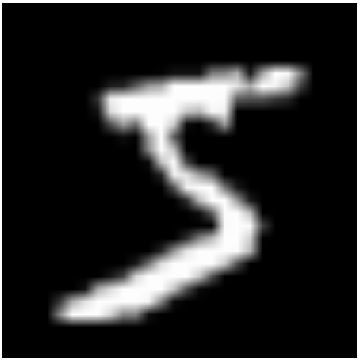

In [10]:
#let's plot a digit
digit = batch[1,,]
options(repr.plot.width=3, repr.plot.height=3)
par(mar = c(0.1, 0.1, 0.1, 0.1))
digit %>% as.raster(. ,max = 255) %>% plot

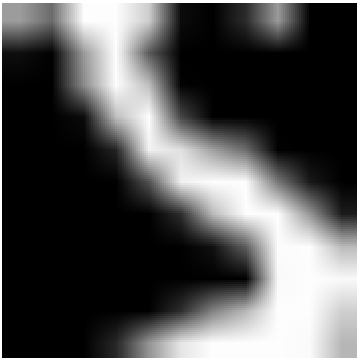

In [13]:
#let's plot a zoomed digit
par(mar = c(0.1, 0.1, 0.1, 0.1))
digit_zoomed = batch[1,10:20,10:20]
digit_zoomed %>% as.raster(. ,max = 255) %>% plot

___

## Tensor Operations

All in all, you can interpret deep learning model as a chained tensor product.

In our initial example, we were building our network by stacking dense layers on top of each other. A layer instance looks like this:

In [ ]:
# do not run
layer_dense(units = 512, activation = "relu")

This layer can be interpreted as a function, which takes as input a 2D tensor and returns another 2D tensor—a new representation for the input tensor. Specifically, the function is as follows (where $\texttt{W}$ is a 2D tensor (weight tensor) and $\texttt{b}$ is a vector (bias tensor), both attributes of the layer)

In [ ]:
# do not run
output = relu(dot(W, input) + b

Let’s unpack this. We have **three tensor operations here** (at the core of tensorflow):
- a **dot product** ($\cdot$) between the input tensor and a tensor named $\texttt{W}$,
- an **addition** ($+$) between the resulting 2D tensor and a vector $\texttt{b}$ , and finally
- an **element-wise operation** ($\texttt{relu}$). $\texttt{relu(x)} = \max(x, 0)$


> A couple of concepts that will be deepened later on:

> #### Bias
> A vector. Equivalent of the intercept coefficient in any regression

> #### Activation function
> The equivalent of the logit function in a logistic regression. Used to introduce non-linearities in the network (which would otherwise result in a mere linear transformation of the input, incapable to grasp non-linear features).

There is an additional operation worth mentioning, which is **tensor reshaping**: nothing more than rearranging its rows and columns to match a target shape

In [113]:
(x = matrix(c(0, 1, 2, 3, 4, 5),
           nrow = 3,
           ncol = 2,
           byrow = TRUE)) %>% print

     [,1] [,2]
[1,]    0    1
[2,]    2    3
[3,]    4    5


In [114]:
# reshape to a vector
(x = array_reshape(x, dim = c(6, 1))) %>% print

     [,1]
[1,]    0
[2,]    1
[3,]    2
[4,]    3
[5,]    4
[6,]    5


In [118]:
# ri-reshape to a matrix
(x = array_reshape(x, dim = c(2, 3))) %>% print

     [,1] [,2] [,3]
[1,]    0    1    2
[2,]    3    4    5


In [119]:
# transpose back to its original shape
(x = t(x) ) %>% print

     [,1] [,2]
[1,]    0    3
[2,]    1    4
[3,]    2    5


### Geometric interpretation of deep learning

You just learned that neural networks consist entirely of **chains of tensor operations** and that all of these tensor operations are just geometric transformations of the input data (in some n-dimensional hyperspace). It follows that you can interpret a neural network as a very complex geometric transformation in a high-dimensional space, implemented via a long series of simple
steps.

Imagine you need to discriminate which side is which in a crumpled paper sheet.

<img src="fig/paper_ball.PNG" width="400">

**Uncrumpling paper balls is what machine learning is about**: finding neat representations for complex, highly folded data manifolds. 

___

## Gradient Based Optimization

This is how things *really* come to be.

As you saw in the previous section, each neural layer from our first network example transforms its input data as follows

In [ ]:
# do not run
output = relu(dot(W, input) + b

In this expression, $\texttt{W}$ and $\texttt{b}$ are tensors that are attributes of the layer. They’re called the *weights* or the *trainable parameters* of the layer (the $\texttt{kernel}$ and $\texttt{bias}$ attributes, respectively). These weights contain the information learned by the network from exposure to training data. Initially, these weight matrices are filled with small random values (a step called random initialization). Of course, there’s no reason to expect that $\texttt{relu(dot(W, input) + b)}$, when $\texttt{W}$ and $\texttt{b}$ are random, would yield any useful representations. The resulting representations are meaningless but they are a starting point. What comes next is **to gradually adjust these weights, based on a feedback signal**. This gradual adjustment, also called training, is basically "**the learning**" that machine learning is all about.

This happens within what's called a **training loop**, which schematically looks as follows:
1. Draw a batch of training samples $\texttt{x}$ and corresponding targets $\texttt{y}$
2. Run the network on $\texttt{x}$ (this is called a **forward pass**, or feedforwarding), to obtain predictions $\texttt{y}$\_$\texttt{pred}$
3. Compute the loss of the network on the batch, a measure of mismatch between $\texttt{y}$\_$\texttt{pred}$ and $\texttt{y}$
4. Update all weights of the network in a way that slightly reduces the loss on this batch

You will eventually end up with a network that slightly reduces the loss on training data: that is, a low mismatch between predictions $\texttt{y_pred}$ and expected targets $\texttt{y}$. The network has *learned* to map its inputs to correct targets. From afar, it may look like magic, but when reduced to elementary steps, it turns out to be simple.

Step 1 sounds easy enough: just I/O code. Steps 2 and 3 are merely the application of a handful of tensor operations, so you could implement these steps purely from what you learned in the previous section. The difficult part is step 4: updating the network’s
weights.

In [162]:
# which are traineble parameters in our MNIST network
network$trainable_weights

[[1]]
Variable(shape=(784, 512), dtype=float32_ref)


[[2]]
Variable(shape=(512,), dtype=float32_ref)


[[3]]
Variable(shape=(512, 10), dtype=float32_ref)


[[4]]
Variable(shape=(10,), dtype=float32_ref)



The approach is to take advantage of the fact that **all operations used in the network are compute the differentiable** , and to **compute the gradient of the loss with regard to the network’s coefficients**. You can then **move the coefficients in the opposite direction from the gradient**, thus decreasing the
loss.

> BTW a **gradient** is nothing more than a n-dimensional derivative, that is a **derivative of a tensor operation** (i.e. a matrix where on the main diagonal you find the derivative on a specific dimension, while partial derivative elsewhere). This thing is also referred as the **Jacobian** matrix.

<img src="fig/1d_loss.PNG" width="200"> <img src="fig/2d_loss.PNG" width="200">

### Chain Rule: the backpropagation algorithm

In the previous algorithm, we casually assumed that because a function is differentiable, we can explicitly compute its derivative. In practice, a neural-network function consists of many tensor operations chained together, each of which has a simple, known derivative. For instance, this is a network $f$ composed of three tensor operations $a$, $b$, and $c$, with weight matrices $W1$, $W2$, and $W3$:

$$f(W1, W2, W3) = a(W1,\, b(W2,\, c(W3))$$

Calculus tells us that a chain of function can be differentiated using the so-called *chain rule*:

$$\frac{d}{dx}f(g(x)) = f'(g(x)) \cdot g'(x)$$

Recursively applying the chain rule to the computation of the gradient values gives rise to an algorithm called *backpropagation*. Backpropagation starts with the final loss value and works backward from the top layers to the bottom layers, applying the chain rule to compute the contribution that each parameter had in the loss value.

Modern frameworks, such as tensorflow, are capable of *symbolic differentiation*, which means that, given a chain of operations with a known derivative, they can compute a gradient function for the whole chain (by applying the chain rule), that **maps every network parameter to gradient values**. When you have access to such a function, the backward pass is simply reduced to a call to this gradient function.

___
## WAIT. Please recap!
Sure.

- This was the input data:

In [ ]:
mnist <- dataset_mnist() train_images <- mnist$train$x

train_images <- array_reshape(train_images, c(60000, 28 * 28))
train_images <- train_images / 255
test_images <- mnist$test$x
test_images <- array_reshape(test_images, c(10000, 28 * 28))
test_images <- test_images / 25

now you understand that our **input images are stored in tensors** of shape $(60,000, 784)$ (training data) and $(10,000, 784)$ (testing data) respectively.

- This was our network

In [ ]:
network = keras_model_sequential() %>% # keras_model_sequential is the basic call to start building the nnet
            # first layer
            layer_dense(units = 512,
                        activation = "relu",
                        input_shape = c(28 * 28),
                        use_bias = T,
                        name='first_layer'
                       ) %>%
            # second layer
            layer_dense(units = 10,
                        activation = "softmax",
                        use_bias = T,
                        name = 'output_layer'
                       )

Now you understand that
1. this network consists in a **chain of two dense layer**, and that
2. each layer applies a few simple tensor operations to the input data, that 
3. these operations involve tensors
4.  weight tensors ($\texttt{W}$ and $\texttt{b}$), which are attributes of the layer, is where the **knowledge** of the network persist

- This was the network-compilation step

In [ ]:
network %>% compile(optimizer = "rmsprop",
                    loss = "categorical_crossentropy",
                    metrics = c("accuracy")
)

Now you understand that
1. $\texttt{categorical}$\_$\texttt{crossentropy}$ is the loss function that is used as a feedback signal for learning the weight tensors (which the training phase will attempt to minimize)
2. The reduction of the loss happens via gradient descent. The exact rules governing a specific use of gradient descent are defined by the $\texttt{'rmsprop'}$ optimizer passed as the first argument. 

Finally, this was the training loop:

In [ ]:
network %>% fit(train_images,
                train_labels,
                epochs = 5,
                batch_size = 128)

Now you understand what's going on when you call $\texttt{fit}$
1. The network will start to iterate on the training data in batches of 128 samples
2. The network will iterate over all batches five times (each iteration over all the training data is called an **epoch**)
3. After these 5 epochs you will have performed 2,345 gradient updates (469 per epoch) and the loss of the network will be sufficiently low that the model will be capable to classify handwritten digits with high accuracy.

___
## Final tips

### 1.  Activation function
Lots of activation function have been developed in time.

#### Hidden layer
Please use $\texttt{relu}$ (Rectified linear unit). It is the simplest and it work the best!

#### Output layer
It depends:
- **Binary classification**: use $\texttt{'sigmoid'}$ 
- **Multiclass classification**
    - **single outcome** possible at a time: use $\texttt{'softmax'}$
    - **multiple outcomes** possible at the same time: use $\texttt{'sigmoid'}$
- **Regression to arbitrary values**: don't use any
    - between O and 1? you can use $\texttt{'sigmoid'}$

In [4]:
lsp(keras, pattern = '^activation')

[1] "activation_elu"          "activation_hard_sigmoid"
 [3] "activation_linear"       "activation_relu"        
 [5] "activation_selu"         "activation_sigmoid"     
 [7] "activation_softmax"      "activation_softplus"    
 [9] "activation_softsign"     "activation_tanh"

### 2. Loss function
It depends:
- **Binary classification**: use $\texttt{'binary_crossentropy'}$
- **Multiclass classification**
    - **single outcome** possible at a time: use $\texttt{'categorical_crossentropy'}$
    - **multiple outcomes** possible at the same time: use $\texttt{'binary_crossentropy'}$
- **Regression to arbitrary values**: $\texttt{'mse'}$
    - between O and 1? you can use $\texttt{'mse'}$ or $\texttt{'binary_crossentropy'}$

In [170]:
lsp(keras, pattern = 'loss')

[1] "loss_binary_crossentropy"            
 [2] "loss_categorical_crossentropy"       
 [3] "loss_categorical_hinge"              
 [4] "loss_cosine_proximity"               
 [5] "loss_hinge"                          
 [6] "loss_kullback_leibler_divergence"    
 [7] "loss_logcosh"                        
 [8] "loss_mean_absolute_error"            
 [9] "loss_mean_absolute_percentage_error" 
[10] "loss_mean_squared_error"             
[11] "loss_mean_squared_logarithmic_error" 
[12] "loss_poisson"                        
[13] "loss_sparse_categorical_crossentropy"
[14] "loss_squared_hinge"

### 3. Optimizer
Lots of optimization function have been developed in time. Currently, for most of tasks, the adaptive moment estimation ($\texttt{adam}$) optimizer works the best and converge to the minimum loss faster than any other algorithm.

In [166]:
lsp(keras, pattern = 'optimizer')

[1] "optimizer_adadelta" "optimizer_adagrad"  "optimizer_adam"    
[4] "optimizer_adamax"   "optimizer_nadam"    "optimizer_rmsprop" 
[7] "optimizer_sgd"

For every hyperparameter you can choose whether to pass the string ($\texttt{'adam'}$) or by calling the equivalent function $\texttt{optimizer}$\_$\texttt{adam}$(), where you can additionally manually specify a few parameters.

### 4. Save model
The training process may require a lot of time. You'd better save your model if you want to use it somewhere else without training it by scratch, or if you want to use any pre-trained model.

A model is stored as a .hdf5 file. Please note what you will have to save separately the structure and the weights!

In [6]:
lsp(keras, pattern = '^save_model')
lsp(keras, pattern = '^load_model')

[1] "save_model_hdf5"         "save_model_weights_hdf5"

[1] "load_model_hdf5"         "load_model_weights_hdf5"

### 5. Make predictions
You may want to predict something... classes? probabilities?

In [175]:
lsp(keras, pattern = 'predict_')

[1] "predict_classes"   "predict_generator" "predict_on_batch" 
[4] "predict_proba"